# Bayesian methods of Machine Learning (Skoltech)

## Home Assignment 2.  Log-Derivative trick. VAE. Mean-field approximation.

<img src="https://go2phystech.ru/wp-content/uploads/2021/02/skolteh.jpeg" width=800 height=200 />

### Important information

$\textbf{Deadline}$: 23:59:59, 3 November 2023 (Friday)\
$\textbf{Rules}$:

- Do not redistribure materials of this homework, they belong to Skoltech.
- This is your individual work. Please, do not consult with the other students and do not copy their work. Otherwise, you will get 0 points.
- Please, respect the homework deadlines!
- This HW is composed of 4 tasks with the corresponding points: task 1 - 2pts, task 2 - 2 pts, task 3 - 4 pts, task 4 - 4 pts. Overall, 12 points.
- We have created a special telegram topic for this homework 2. There you can questions if anything is unclear. However, please do not post your solution or ask for it in the subgroup's messages, otherwise, you will get 0 points.
- After the grades are posted, you will have one week to appeal (offline, on campus).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as TD
import torch.optim as optim
from torch.distributions import Normal, Bernoulli, Independent
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from collections import defaultdict
from tqdm.notebook import tqdm
from typing import List, Union
import gc
import os
import numpy as np
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from IPython.display import Image, display
from IPython.core.display import HTML
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device='cuda'
USE_CUDA=True

## Task 1. Log-derivative Trick (2 pts)

1. In seminar 6 we have encountered a problem with Monte Carlo estimation deriving the ELBO gradient at the E-step, since the distribution function $q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi})$ depends on the differentiation parameters $\boldsymbol{\phi}$.
\begin{align*}
    \nabla_{\boldsymbol{\phi}} \mathcal{L} (\boldsymbol{\phi}, \boldsymbol{\theta}) &= \nabla_{\boldsymbol{\phi}} \int q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) \left[\log p(\mathbf{x}, \mathbf{z} | \boldsymbol{\theta}) - \log q(\mathbf{z}| \mathbf{x}, \boldsymbol{\phi}) \right] d \mathbf{z} \\
    & \neq  \int q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) \nabla_{\boldsymbol{\phi}} \left[\log p(\mathbf{x}, \mathbf{z} | \boldsymbol{\theta}) - \log q(\mathbf{z}| \mathbf{x}, \boldsymbol{\phi}) \right] d \mathbf{z} \\
\end{align*}
The Reparametrization trick allowed us to skip the gradient and get a Monte Carlo estimate.

    However, there is another way that uses the so-called **log-derivative trick**:
    \begin{align*}
        \nabla_\xi  \log q(\eta| \xi) = \frac{\nabla_\xi q(\eta| \xi)}{q(\eta| \xi)}.
    \end{align*}
    
    Problems:
    1. Get the Monte Carlo estimate of the gradient using the formula for the derivative of the logarithm. (1 pt)
    2. The final expression works significantly worse than the reparametrization trick. Namely, it has a huge variance. Try to describe the intuition why this estimation has a high variance (you need to think about what order and sign the terms in the expression will have). (1 pt)

##### your answer is here

1.

\begin{align*}
  \nabla_{\phi}L(\phi,\theta) = … =
  E_{q(z|x,\phi)}\nabla_{\phi}logq(z|x,\phi)[logp(x, z|\theta) - logq(z|x,\phi)] =
  \frac{1}{N}\sum_{n=1}^{N}\nabla_{\phi}log(z_n|x,\phi)[logp(x,z_n|\theta) -logq(z_n|x,\phi)], \text{where $z_n \sim q(z|x, \phi)$}
\end{align*}

2.
Думаю, большой разброс нашей оценки (квадрат матожидания оценки минус истинное значение лосса) может получиться из-за ошибок семплирования. Вернее, не ошибок, а неточностей или скорее даже, выбросов, которые могут возникнуть в результате семплирования. От этого может поехать как само значение $z_n$, так и градиент логарифма, из-за чувствительности дисперсии. Ошибка так же может возникнуть в результате численного подсчета градиентна логарифма при таком подходе.

## Task 2. VAE with no-gaussian decoder (2 pts)

We have familiarized ourselves with the decoder model that describes the conditional distribution $p(x|z,\theta)$. We have considered this model as gaussian distribution for simplicity. Thus, we have assumed that data is described by normal distribution with mean and covariance matrix that are trainable. Nonetheless, one can choose another distribution for certain tasks.

Let $\textbf{MNIST}$ data be the data used in this task. Our data looks contains these images:

![Autoencoder reconstructions](https://github.com/bayesgroup/deepbayes-2018/blob/master/day2_vae/ae_reconstructions.png?raw=true)

Each image of this dataset is the combination of black and white pixels. Thus, decoder tries to set either white or black color for each pixel of the generated image. So, we set either 0 or 1 for each coordinate of this generated image. As a consequence of that, the output of our decoder has 2 possible outcomes and one can take $\textbf{bernoulli}$ distribution as $p(x|z,\theta)$.


A variational autoencoder consists of two components. The first component is a probabilistic model for observations:
\begin{align}
& p(x, z \mid \theta) =  p(z) p(x \mid z, \theta) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid z, \theta) = \prod_{i = 1}^D p_i(z, \theta)^{x_i} (1 - p_i(z, \theta))^{1 - x_i}.
\end{align}
The second component is a variational approximation, used to compute the lower bound on marginal likelihood (VAE uses the negative lower bound as a loss function)
\begin{equation}
q(z \mid x, \phi) = \mathcal N(z \mid \mu(x, \phi), \operatorname{diag}(\sigma^2(x, \phi))).
\end{equation}
The lower bound for probability of observing $x$ from a minibatch is
$$ \mathcal L(x, \theta, \phi) = \mathbb E_{q(z \mid x, \phi)} \left[ \log p(x \mid z, \phi) + \log p(z) - \log q(z \mid x, \theta) \right] $$
However, it is impossible to compute this expectation. The standard practice is to approximate it with the following one-sample Monte-Carlo estimate:
\begin{align*}
\log p(x \mid z_0, \phi) + \log p(z_0) - \log q(z_0 \mid x, \theta) \\
z_0 = \mu(x, \phi) + \sigma^2(x, \phi)^T \varepsilon_0 \\
\varepsilon_0 \sim \mathcal N(0, I)
\end{align*}
*Note that this choice of the Monte-Carlo estimate for expectation is crucial and is typically reffered to as* **reparametrization trick.** For more details see [Auto-encoding Variational Bayes](https://arxiv.org/abs/1312.6114) paper.

Finally, to train the model we average the lower bound values over the minibatch and then maximize the average with gradient ascent:
$$ \frac{1}{N} \sum_{n=1}^N \log p(x_n \mid z_n, \phi) + \log p(z_n) - \log q(z_n \mid x_n, \theta) \rightarrow \max_{\theta, \phi} $$

### Encoder and decoder

$q(z\mid x, \theta)$ is usually called encoder and $p(x \mid z, \phi)$ is usually called decoder. To parametrize these distributions we introduce two neural networks:

- *enc* takes $x$ as input and return $2 \times d$-dimensional vector to parametrize mean and standard deviation of $q(z \mid x, \theta)$
- *dec* takes a latent representation $z$ and returns the logits of distribution $p(x \mid z, \phi)$.

The computational graph has a simple structure of autoencoder. The only difference is that now it uses a stochastic variable $\varepsilon$:

![vae](https://github.com/bayesgroup/deepbayes-2018/blob/master/day2_vae/vae.png?raw=true)

Below we initialize a couple of simple fully-connected networks to model the two distributions.

### 2.0 data for the experiment

Download MNIST data for this experiment an d divide it to train and test subsets.

In [3]:
# train dataset
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='.', train=True, download=True,
          transform=transforms.ToTensor()),
    batch_size=100, shuffle=True )

# Test dataset
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='.', train=False, transform=transforms.ToTensor()),
    batch_size=100, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 391381850.78it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 48222808.05it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 156323125.53it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16696344.23it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



### 2.1 Initializtion of models  (0.5 pt)

First of all, we initialize netorks for encoder and decoder  correspondingly. Below, we choose dimension of latent and data spaces. You should write appropriate architectures for encoder and decoder. (0.5 pt)

In [138]:
d = 32  # dimension of latent space
nh =  100 # dimensions of intermediate representations.
D = 28 * 28 # dimension of data space

In [154]:
# encoder
# your code is here
class Encoder(nn.Module):
    def __init__(self, in_features = D, inter = nh, out_features = d):
        
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Flatten(), # in_features = D
            nn.Linear(in_features, 512),
            nn.MaxPool1d(kernel_size=2), # 256
            nn.ReLU(),
            nn.Linear(256, inter),
            nn.ReLU()
        )
        self.fc = nn.Linear(inter, out_features)
    
    def forward(self, x, inter = nh, out_features = d):
        x = self.net(x)
        
        mean = self.fc(x)
        std  = self.fc(x)
        
        return torch.cat((mean, std), dim = 1)

enc = Encoder(in_features = D, inter = nh, out_features = d)

Please, pay your attention! When we built decoder for $p(x|z,\phi)$ that is normal distribution, then such decoder has 2$D$ outputs, but you should correct outputs in this case of Bernoulli distribution.

In [155]:
# decoder
# your code is here
class Decoder(nn.Module):
    def __init__(self, in_features = d, inter = nh, out_features = D):
        
        super().__init__()
        
        self.net = nn.Sequential(
                    nn.Linear(in_features, inter),
                    nn.ReLU(),
                    nn.Linear(inter, out_features//2),
                    nn.ReLU(),
                    nn.Linear(out_features//2, out_features)
        )
    
    def forward(self, x):
        x = self.net(x)
        return x

dec = Decoder(in_features = d, inter = nh, out_features = D)

In [156]:
enc = enc.to(device)
dec = dec.to(device)

### 2.2  VAE Loss function.  (0.5 pt)

Implement the line that corresponds to the loss function for the variational autoencoder (0.5 pt)

> Finally, to train the model we average the lower bound values over the minibatch and then maximize the average with gradient ascent:
$$ \frac{1}{N} \sum_{n=1}^N \log p(x_n \mid z_n, \phi) + \log p(z_n) - \log q(z_n \mid x_n, \theta) \rightarrow \max_{\theta, \phi} $$

In [157]:
def loss_vae(x, encoder, decoder):
    """
    TODO
    returns
    1. the avergave value of negative ELBO across the minibatch x
    2. and the output of the decoder
    """
    batch_size = x.size(0)
    encoder_output = encoder(x)
    pz = Independent(Normal(loc=torch.zeros(batch_size, d).to(device),
                            scale=torch.ones(batch_size, d).to(device)),
                     reinterpreted_batch_ndims=1)
    qz_x = Independent(Normal(loc=encoder_output[:, :d],
                              scale=torch.exp(encoder_output[:, d:])),
                       reinterpreted_batch_ndims=1)

    z = qz_x.rsample()
    decoder_output = decoder(z)
    px_z = Independent(Bernoulli(logits=decoder_output),
                       reinterpreted_batch_ndims=1)
    
    pred = (x > 0.5).float()
    loss = - torch.mean(px_z.log_prob(pred) + pz.log_prob(z) - qz_x.log_prob(z))

    return loss, decoder_output

### 2.3 Training

The cell below implements a simple training function that can be used for both models(encoder and decoder).

In [158]:
from itertools import chain

def train_model(loss, model, batch_size, num_epochs, learning_rate):
    gd = torch.optim.Adam(
        chain(*[x.parameters() for x in model
                if (isinstance(x, nn.Module) or isinstance(x, nn.Parameter))]),
        lr=learning_rate)
    train_losses = []
    test_results = []
    for _ in range(num_epochs):
        for i, (batch, _) in enumerate(train_loader):
            total = len(train_loader)
            gd.zero_grad()
            batch = batch.view(-1, D).to(device)
            loss_value, _ = loss(batch, *model)
            loss_value.backward()
            train_losses.append(loss_value.item())
            if (i + 1) % 10 == 0:
                print('\rTrain loss:', train_losses[-1],
                      'Batch', i + 1, 'of', total, ' ' * 10, end='', flush=True)
            gd.step()
        test_loss = 0.
        for i, (batch, _) in enumerate(test_loader):
            batch = batch.view(-1, D).to(device)
            batch_loss, _ = loss(batch, *model)
            test_loss += (batch_loss - test_loss) / (i + 1)
        print('\nTest loss after an epoch: {}'.format(test_loss))

In [159]:
# choose appropiate hyper-parameters
# your code is here
BATCH_SIZE = 64
NUM_EPOCHS = 5
LR = 0.001

In [160]:
train_model(loss_vae, model=[enc, dec], batch_size=BATCH_SIZE, num_epochs=NUM_EPOCHS, learning_rate=LR)

Train loss: 179.4387969970703 Batch 600 of 600            
Test loss after an epoch: 170.81927490234375
Train loss: 141.96908569335938 Batch 600 of 600           
Test loss after an epoch: 146.11715698242188
Train loss: 135.66603088378906 Batch 600 of 600           
Test loss after an epoch: 137.31854248046875
Train loss: 129.3802490234375 Batch 600 of 600            
Test loss after an epoch: 131.3087921142578
Train loss: 128.81297302246094 Batch 600 of 600           
Test loss after an epoch: 128.5287322998047


### 2.4 Inference of VAE model (0.5 pt)

You should write the line, where we take latent codes and apply decoder model for these latent codes. (0.5 pt)

In [161]:
def sample_vae(dec, n_samples=50):
    with torch.no_grad():
        
        norm = Independent(Normal(loc=torch.zeros(d).to(device),
                            scale=torch.ones(d).to(device)),
                     reinterpreted_batch_ndims=1)
        z = norm.rsample([n_samples])
        samples = torch.sigmoid(dec(z))
        samples = samples.view(n_samples, 28, 28).cpu().numpy()
    return samples

def plot_samples(samples, h=5, w=10):
    fig, axes = plt.subplots(nrows=h,
                             ncols=w,
                             figsize=(int(1.4 * w), int(1.4 * h)),
                             subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i], cmap='gray')

We use trained decoder for the inference and obtain such results.

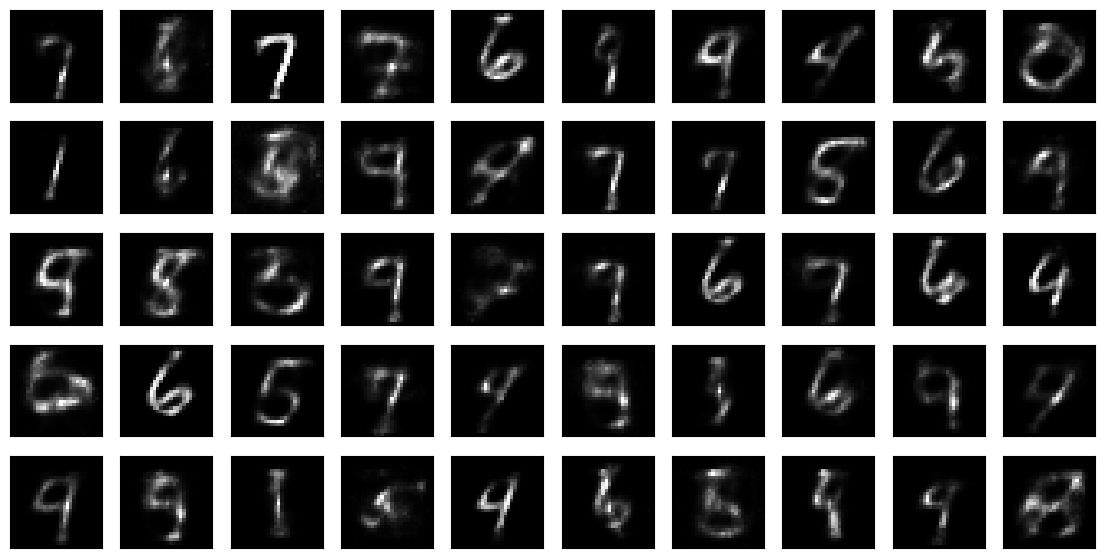

In [162]:
plot_samples(sample_vae(dec=dec))

### 2.5 Plot reconstructions

Reconstruction is performed according to the following scenario. We take $x$ from dataset and perform mapping for this $x$ using the encoder model $q(z|x,\phi)$, then we make a sample from this distribution via reparametrization trick and feed this sample to the decoder model $p(x|z,\theta)$. We beleive that the resulting recostruction will be similar to the initial data point. This way, our generated image is referred to as a reconstruction.

In [163]:
def plot_reconstructions(loss, model):
    with torch.no_grad():
        batch = (test_loader.dataset.data[:25].float() / 255.)
        batch = batch.view(-1, D).to(device)
        _, rec = loss(batch, *model)
        rec = torch.sigmoid(rec)
        rec = rec.view(-1, 28, 28).cpu().numpy()
        batch = batch.view(-1, 28, 28).cpu().numpy()

        fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(14, 7),
                                 subplot_kw={'xticks': [], 'yticks': []})
        for i in range(25):
            axes[i % 5, 2 * (i // 5)].imshow(batch[i], cmap='gray')
            axes[i % 5, 2 * (i // 5) + 1].imshow(rec[i], cmap='gray')

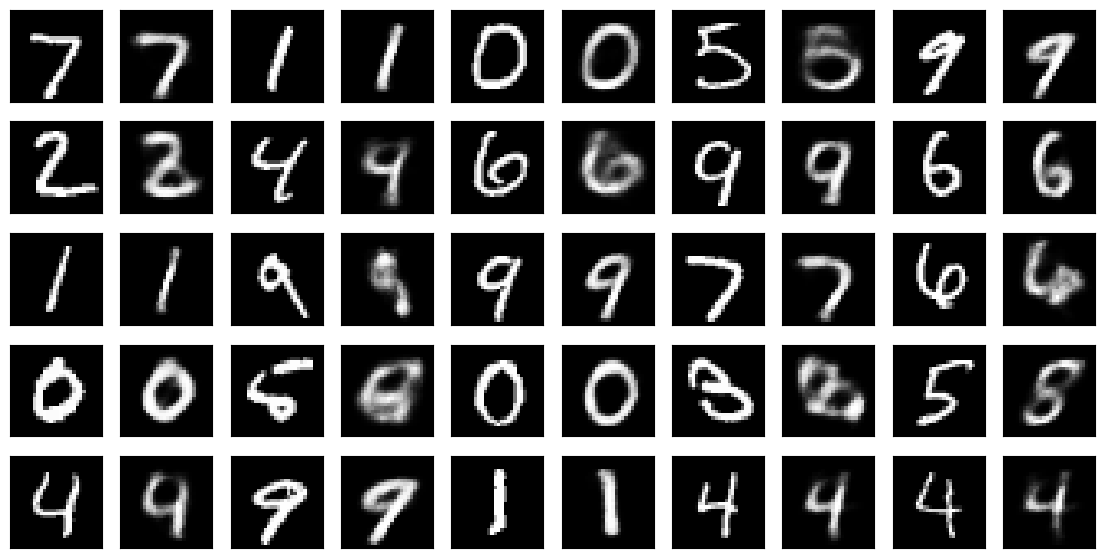

In [164]:
plot_reconstructions(loss_vae, [enc, dec])

### 2.6 Plot interpolations

The first attempt to understand latent space of VAE is interploations. We take two latent codes $z_{0}$ and $z_{1}$ and build the forward line between them. Then we make samples along this line and decode them.

In [165]:
def plot_interpolations(encoder, decoder):
    with torch.no_grad():
        batch = (test_loader.dataset.data[:10].float() / 255.)
        batch = batch.view(-1, D).to(device)
        batch = encoder(batch)
        z_0 = batch[:5, :d].view(5, 1, d)
        z_1 = batch[5:, :d].view(5, 1, d)

        alpha = torch.linspace(0., 1., 10).to(device)
        alpha = alpha.view(1, 10, 1)

        interpolations_z = (z_0 * alpha + z_1 * (1 - alpha))
        interpolations_z = interpolations_z.view(50, d)
        interpolations_x = torch.sigmoid(decoder(interpolations_z))
        interpolations_x = interpolations_x.view(5, 10, 28, 28).cpu().numpy()

    fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(14, 7),
                             subplot_kw={'xticks': [], 'yticks': []})
    for i in range(50):
        axes[i // 10, i % 10].imshow(interpolations_x[i // 10, i % 10], cmap='gray')

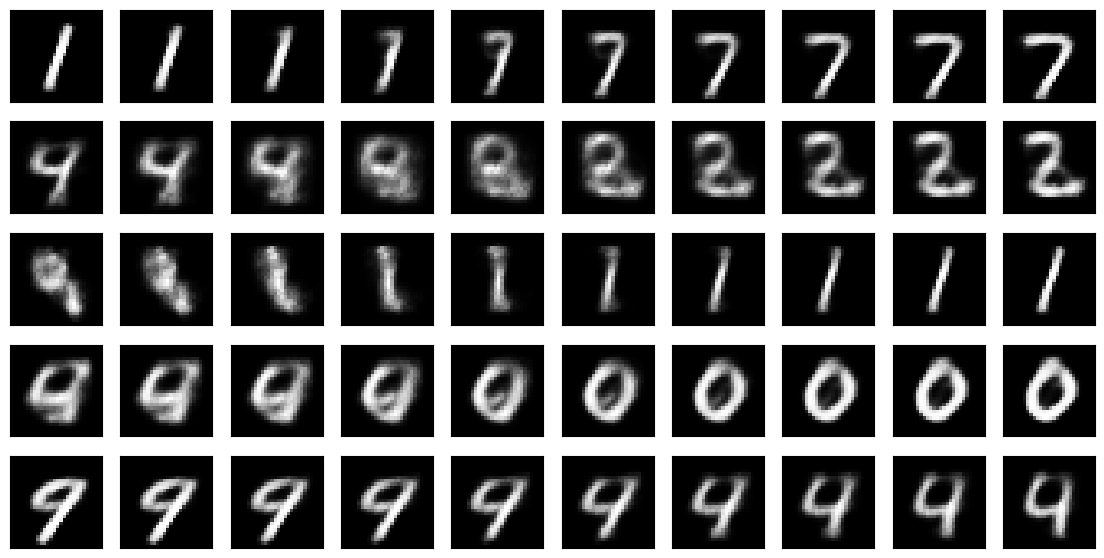

In [166]:
plot_interpolations(enc, dec)

### 2.7 Plot latent space of VAE model

Also, one can learn the structure of latent spaces with the help of the methods of geometric ml(metric learning) such as [T-sne](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)

In [167]:
def plot_tsne(objects, labels):
    from sklearn.manifold import TSNE
    embeddings = TSNE(n_components=2).fit_transform(objects)
    plt.figure(figsize=(8, 8))
    for k in range(10):
        embeddings_for_k = embeddings[labels == k]
        plt.scatter(embeddings_for_k[:, 0], embeddings_for_k[:, 1],
                    label='{}'.format(k))
    plt.legend()

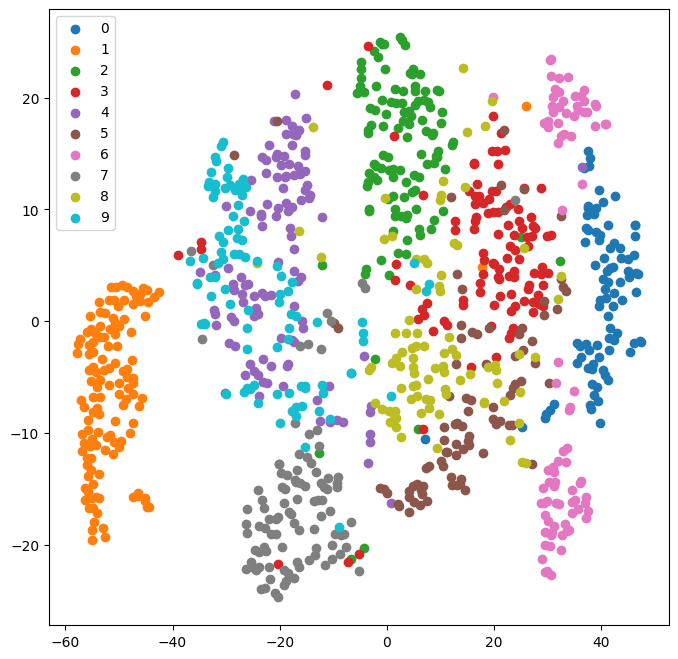

In [168]:
with torch.no_grad():
    batch = (test_loader.dataset.data[:1000].float() / 255.)
    batch = batch.view(-1, D).to(device)

    latent_variables = enc(batch)[:, :d]
    latent_variables = latent_variables.cpu().numpy()
    labels = test_loader.dataset.targets[:1000].numpy()

plot_tsne(latent_variables, labels)

###   2.8 Observations (0.5 pts)

Write down your observations on the plots above and answer the following questions:
  
- Is the latent space regularly covered?
- Is there any correlation between the resulting T-SNE encoding and the digit label?

1. Зависит от того, как посмотреть. Я же наблюдаю оюласти сосредоточенности определённых цифр, при этом есть проплешины.


2. На TSNE видим смешивание классов 5, 8, 3. На картинках выше видели подобный эффект, так что в этом плане связь видна. Более того, если посмотреть на другие цифры (классы), то уверенность TSNE совпадает со зрительной схожестью. Так что положительная корреляция есть.

## Task 3. Mean-field approximation (4 pts)

We have already built approximation by mean-field methodology during the 5th seminar. This task is almost the same, but you will be asked to try out another distributions.

Consider the following model for i.i.d data $\mathcal{D}=\{x_1,\dots,x_N\}$, $N\geq2$ and $x_{i} \in \mathbb{R}$

We assume that our data distribution is described by a uniform distribution with the following prior distribution over the parameters:
\begin{align*}
p(x \mid \lambda)&=\operatorname{Uniform}(x\mid0,\; \lambda)\\
p(\lambda \mid \tau) &= \operatorname{Pareto}(\lambda\mid \gamma_0,\; \alpha_0\tau),\\
p(\tau) &= \operatorname{Gamma}(\tau\mid u_0,\; v_0),
\end{align*}

$\textbf{Full task}:$ Find the approximation of true posterior $p(\lambda,\tau\mid\mathcal{D})$ using mean-field approximation $q(\lambda,\tau)=q_{\lambda}(\lambda)q_{\tau}(\tau)$

$\textbf{Recap}:$

Densities:
\begin{align*}
\operatorname{Uniform}(x\mid a, b) &= \frac{1}{b-a},\;\; x \in [a, b]\\
\operatorname{Pareto}(x\mid x_m, \alpha) &= \frac{\alpha x_m^{\alpha}}{x^{\alpha+1}},\;\; x \geq x_m\\
\operatorname{Gamma}(x\mid\alpha, \beta) &= \frac{\beta^{\alpha}}{\Gamma(\alpha)} x^{\alpha-1} e^{-\beta x},\;\; x \geq 0\\
\end{align*}

Moments:
$$
X\sim\operatorname{Gamma}(\alpha, \beta)\Rightarrow \mathbb{E}X=\frac{\alpha}{\beta}
$$
$$
X\sim\operatorname{Pareto}(x_m, \alpha), \text{ and } \alpha>1 \Rightarrow \mathbb{E}X=\frac{\alpha x_m}{\alpha-1}, \text{ and }\;\mathbb{E}\ln X=\ln x_m + \frac{1}{\alpha}
$$

$\textbf{Hint}$:
Don't forget about conjugate distributions.

### 3.1 Derive formulas for the first parameter (1 pt)

Firstly, you should derive and get formulas for $ q_{\lambda}(\lambda)$

##### your derivation is here (latex code)

### 3.2 Derive formulas for the second parameter (1 pt)

Secondly, you should derive and get formulas for $ q_{\tau}(\tau)$

###### your derivation is here (latex code)

### 3.3 Iterative processes of mean-field  approximation (2 pts)

Code the iterative recomputation process for this task as it has been done in the 5th seminar. Run your process and plot your approximation for $p(\lambda,\tau\mid\mathcal{D})$ for all iterations. It means that you should demonstrate how your approximation changes as your method is training.

$\textbf{Note}$: You are required to demonstrate all the relevant calculations.

In [ ]:
# your code is here

## Task 4. VAE on CIFAR-10 dataset (4 pts)

In this task you will implement VAE model for CIFAR10 dataset.

### 4.1 utils for this task

In [169]:
TICKS_FONT_SIZE = 12
LEGEND_FONT_SIZE = 12
LABEL_FONT_SIZE = 14
TITLE_FONT_SIZE = 16

In [170]:
def plot_training_curves(train_losses, test_losses, logscale_y=False, logscale_x=False):
    n_train = len(train_losses[list(train_losses.keys())[0]])
    n_test = len(test_losses[list(train_losses.keys())[0]])
    x_train = np.linspace(0, n_test - 1, n_train)
    x_test = np.arange(n_test)

    plt.figure()
    for key, value in train_losses.items():
        plt.plot(x_train, value, label=key + '_train')

    for key, value in test_losses.items():
        plt.plot(x_test, value, label=key + '_test')

    if logscale_y:
        plt.semilogy()

    if logscale_x:
        plt.semilogx()

    plt.legend(fontsize=LEGEND_FONT_SIZE)
    plt.xlabel('Epoch', fontsize=LABEL_FONT_SIZE)
    plt.ylabel('Loss', fontsize=LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    plt.grid()
    plt.show()

In [171]:
def load_CIFAR10():
    train_data = torchvision.datasets.CIFAR10(root="./", train=True, download=True)
    test_data = torchvision.datasets.CIFAR10(root="./", train=False, download=True)
    train_data, test_data = train_data.data, test_data.data

    return train_data, test_data

In [172]:
def _load_dataset(name: str):

    if name == "cifar10":
        return load_CIFAR10()
    else:
        raise ValueError("The argument name must have the value  'cifar10'")


def load_dataset(
    name, flatten: bool = False, binarize: bool = True
):

    train_data, test_data = _load_dataset(name)

    train_data = train_data.astype("float32")
    test_data = test_data.astype("float32")

    if binarize:
        train_data = (train_data > 128).astype("float32")
        test_data = (test_data > 128).astype("float32")
    else:
        train_data = train_data / 255.0
        test_data = test_data / 255.0

    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    if flatten:
        train_data = train_data.reshape(len(train_data.shape[0]), -1)
        test_data = test_data.reshape(len(train_data.shape[0]), -1)

    return train_data, test_data

In [173]:
def show_samples(
    samples,
    title,
    figsize=None,
    nrow=None,
) -> None:

    if isinstance(samples, np.ndarray):
        samples = torch.FloatTensor(samples)
    if nrow is None:
        nrow = int(np.sqrt(len(samples)))
    grid_samples = make_grid(samples, nrow=nrow)

    grid_img = grid_samples.permute(1, 2, 0)
    if figsize is None:
        figsize = (6, 6)
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.imshow(grid_img)
    plt.axis("off")
    plt.show()


def visualize_images(data: np.ndarray, title: str) -> None:
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = data[idxs]
    show_samples(images, title)

In [174]:
def train_epoch(model, train_loader, optimizer, use_cuda, loss_key='total'):
    model.train()

    stats = defaultdict(list)
    for x in train_loader:
        if use_cuda:
            x = x.cuda()
        losses = model.loss(x)
        optimizer.zero_grad()
        losses[loss_key].backward()
        optimizer.step()

        for k, v in losses.items():
            stats[k].append(v.item())

    return stats


def eval_model(model, data_loader, use_cuda):
    model.eval()
    stats = defaultdict(float)
    with torch.no_grad():
        for x in data_loader:
            if use_cuda:
                x = x.cuda()
            losses = model.loss(x)
            for k, v in losses.items():
                stats[k] += v.item() * x.shape[0]

        for k in stats.keys():
            stats[k] /= len(data_loader.dataset)
    return stats


def train_model(
    model,
    train_loader,
    test_loader,
    epochs,
    lr,
    use_tqdm=False,
    use_cuda=False,
    loss_key='total_loss'
):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = defaultdict(list)
    test_losses = defaultdict(list)
    forrange = tqdm(range(epochs)) if use_tqdm else range(epochs)
    if use_cuda:
        model = model.cuda()

    for epoch in forrange:
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, use_cuda, loss_key)
        test_loss = eval_model(model, test_loader, use_cuda)

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return dict(train_losses), dict(test_losses)

In [175]:
def get_normal_KL(mean_1, log_std_1, mean_2=None, log_std_2=None):
    """
        This function should return the value of KL(p1 || p2),
        where p1 = Normal(mean_1, exp(log_std_1)), p2 = Normal(mean_2, exp(log_std_2) ** 2).
        If mean_2 and log_std_2 are None values, we will use standard normal distribution.
        Note that we consider the case of diagonal covariance matrix.
    """
    if mean_2 is None:
        mean_2 = torch.zeros_like(mean_1)
    if log_std_2 is None:
        log_std_2 = torch.zeros_like(log_std_1)

    first = 1 / torch.exp(log_std_2) ** 2 * torch.exp(log_std_1) ** 2

    second = (mean_2 - mean_1) * (1 / torch.exp(log_std_2) ** 2) * (mean_2 - mean_1)

    third = 1

    fourth = torch.log((torch.exp(log_std_2) ** 2) / (torch.exp(log_std_1) ** 2))

    return 1/2 * (first + second - third + fourth)

In [176]:
def get_normal_nll(x, mean, log_std):
    """
        This function should return the negative log likelihood log p(x),
        where p(x) = Normal(x | mean, exp(log_std) ** 2).
        Note that we consider the case of diagonal covariance matrix.
    """

    return log_std + 0.5 * torch.log(torch.tensor(2) * np.pi) + (x - mean) * torch.exp(-2 * log_std) / 2 * (x - mean)


### 4.2 Uploading of data

100%|██████████| 170498071/170498071 [00:11<00:00, 14552947.01it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


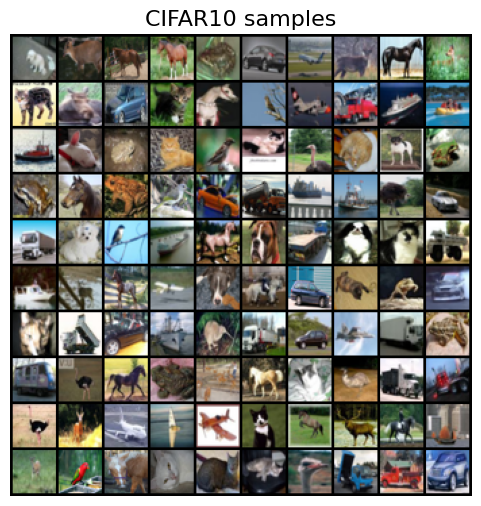

In [177]:
train_data, test_data = load_dataset('cifar10', flatten=False, binarize=False)
visualize_images(train_data, 'CIFAR10 samples')

Here the model architecture will be almost the same as in seminar 7 with the following differences:
* Now our encoder and decoder will be convolutional.
* We do not fit the covariance matrix $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z})$ in the generative distribution $p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta})$. We assume that it is identical ($\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}) = \mathbf{I}$). We will use the $\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z})$ means of the generative distribution $p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta})$ as model samples.
* Model objective is slightly modified ELBO:
$$
    \mathcal{L}(\boldsymbol{\phi}, \boldsymbol{\theta}) = \mathbb{E}_{q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi})} \log p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) - \beta * KL (q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) || p(\mathbf{z})).
$$
Here we introduce the parameter $\beta$. It reweights KL term in the total loss. We will discuss the choice of this parameter later in the course. In this exercise you have to play with it, starting with the value $\beta = 1$ (standard ELBO).

### 4.3 Convoluitonal Encoder (1 pt)

In this , you should define convolutional encoder that will return means and diagonal deviations.

In [233]:
class ConvEncoder(nn.Module):
    def __init__(self, input_shape, n_latent):
        super().__init__()
        self.input_shape = input_shape
        self.n_latent = n_latent
        # ====
        # your code
        # the possible variant of the architecture:
        # conv2d(32) -> relu -> conv(64) -> relu -> conv(128) -> relu -> conv(256) -> fc(2 * n_latent)
        # but we encourage you to create your own

        # ====
        
        self.net = nn.Sequential(
                    nn.Conv2d(input_shape[0], 32, kernel_size=(3, 3), padding='same'),
                    nn.ReLU(),
                    nn.Conv2d(32, 64, kernel_size=(3, 3), padding='same'),
                    nn.ReLU(),
                    nn.Conv2d(64, 128, kernel_size=(3, 3), padding='same'),
                    nn.ReLU(),        
                    nn.MaxPool2d(kernel_size=(2, 2)),
                    nn.Conv2d(128, 256, kernel_size=(3, 3)),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=(2,2)),
                    nn.Flatten(),
                    nn.Linear(7*7*256, 2*n_latent)
        )


    def forward(self, x):
        # ====
        # your code
        # 1) apply convs
        # 2) reshape the output to 2d matrix for last fc layer
        # 3) apply fc layer

        # ====
        x = self.net(x)
        return x


### 4.4 Convolutional decoder (1 pt)

In this , you should define convolutional decoder that will return your generated samples

In [234]:
class ConvDecoder(nn.Module):
    def __init__(self, n_latent, output_shape):
        super().__init__()
        self.n_latent = n_latent
        self.output_shape = output_shape

        self.base_size = (128, output_shape[1] // 8, output_shape[2] // 8)
        # ====
        # your code
        # the possible variant of the architecture:
        # fc -> conv2dtranspose(128) -> relu -> conv2dtranspose(64) -> relu
        # -> conv2dtranspose(32) -> relu -> conv2dtranspose(3)
        # but we encourage you to create your own architecture

        # ====
        
        self.relu  = nn.ReLU()
        self.fc1   = nn.Linear(n_latent, (self.n_latent) * (self.output_shape[1] // 4) * (self.output_shape[2] // 4))
        self.conv1 = nn.ConvTranspose2d(n_latent, 128, kernel_size = (7, 7))
        self.conv2 = nn.ConvTranspose2d(128, 64, kernel_size = (7, 7))
        self.conv3 = nn.ConvTranspose2d(64, 32, kernel_size = (7, 7))
        self.conv4 = nn.ConvTranspose2d(32, 3, kernel_size = (7, 7))



    def forward(self, z):
        # ====
        # your code
        # 1) apply fc layer
        # 2) reshape the output to 4d tensor
        # 3) apply conv layers

        # ====
        z = self.fc1(z)
        z = z.reshape((-1, self.n_latent, self.output_shape[1] // 4, self.output_shape[2] // 4))
        z = self.conv1(z)
        z = self.conv2(self.relu(z))        
        z = self.conv3(self.relu(z))        
        z = self.conv4(self.relu(z))
        
        return z

### 4.5 Convolutional VAE model (2 pts)

Now it is time to implement VAE model for image dataset.

- Firstly, you should fill in the ```forward``` function (1 pt)
- Secondly, you should fill in the ```loss``` function (1 pt)

In [235]:
class ConvVAE(nn.Module):
    def __init__(self, input_shape, n_latent, beta=1):
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.n_latent = n_latent
        self.beta = beta

        self.encoder = ConvEncoder(self.input_shape, self.n_latent)
        self.decoder = ConvDecoder(self.n_latent, self.input_shape)

    def prior(self, n, use_cuda=True):

        z = torch.randn(n, self.n_latent).cuda()
        if use_cuda:
            z = z.cuda()
        return z

    def forward(self, x):
        # ====
        # your code
        # 1) apply encoder to get mu_z, log_std_z
        # 2) apply reparametrization trick (use self.prior)
        # 3) apply decoder to get mu_x (which corresponds to reconstructed x)

        # ====
        encoder = self.encoder(x)
        mu_z, log_std_z = encoder[:, :encoder.shape[1] // 2], encoder[:, encoder.shape[1] // 2:]
        z = mu_z + torch.exp(log_std_z) * self.prior(x.shape[0])
        mu_x = self.decoder(z)

        return mu_z, log_std_z, mu_x


    def loss(self, x):
        # ====
        # your code
        # 1) make forward step to get mu_z, log_std_z, x_recon
        # 2) calculate recon_loss (use get_normal_nll)
        # 3) calcucalte kl_loss (use get_normal_KL)

        # ====
        
        mu_z, log_std_z, mu_x = self(x)
        recon_loss = torch.sum(get_normal_nll(x, mu_x, torch.tensor(0)))
        kl_loss = torch.sum(get_normal_KL(mu_z, log_std_z, torch.zeros_like(mu_z), torch.zeros_like(log_std_z)))

        return {'elbo_loss': recon_loss + self.beta * kl_loss,
                'recon_loss': recon_loss,
                'kl_loss': kl_loss}
        


    def sample(self, n):
        with torch.no_grad():

            x_recon = self.decoder(self.prior(n))
            samples = torch.clamp(x_recon, -1, 1)
        return samples.cpu().numpy() * 0.5 + 0.5

### 4.6 Training

In [ ]:
# ====
# your code
# choose these parameters

BATCH_SIZE = 64 # any adequate value
EPOCHS     = 5 # < 16
LR         = 0.001 # < 1e-3
N_LATENS   = 256 # 128 < _ < 1024
BETA       = 0.2 # 0.1 < _ < 10
# ====

# we center the data, because it helps the model to fit better
centered_train_data = train_data * 2 - 1
centered_test_data = test_data * 2 - 1

train_loader = torch.utils.data.DataLoader(centered_train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(centered_test_data, batch_size=BATCH_SIZE)

model = ConvVAE((3, 32, 32), N_LATENS, BETA)

train_losses, test_losses = train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    lr=LR,
    loss_key='elbo_loss',
    use_tqdm=True,
    use_cuda=True,
)

 20%|██        | 1/5 [00:23<01:34, 23.62s/it]

In [ ]:
for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))
plot_training_curves(train_losses, test_losses)

In [ ]:
samples = model.sample(100)
USE_CUDA=True
x = next(iter(test_loader))[:50]

if USE_CUDA:
    x = x.cuda()

with torch.no_grad():
    z, _ = model.encoder(x)
    x_recon = torch.clamp(model.decoder(z), -1, 1)
reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
reconstructions = reconstructions.cpu().numpy()

x = next(iter(test_loader))[:20].cuda()
with torch.no_grad():
    z, _ = model.encoder(x)
    z1, z2 = z.chunk(2, dim=0)
    interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
    interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
    interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
interps = interps.cpu().numpy()

show_samples(reconstructions, 'CIFAR10 reconstructions')
show_samples(samples, 'CIFAR10 samples')
show_samples(interps, 'CIFAR10 interpolation')